#### Visualizamos una imagen DICOM y sus anotaciones 

Mostrando imagen aleatoria con ID: 1a52264b19da38964392d40a72362fdd y Study ID: 5b2344cf2aeda414c766672b3687a44c
Imagen 1a52264b19da38964392d40a72362fdd tiene Photometric Interpretation: MONOCHROME2
ROI #173: ['Suspicious Calcification'], BIRADS: BI-RADS 3

Metadatos asociados a la imagen:
Photometric Interpretation (desde CSV): MONOCHROME2
Window Center & Width Explanation: linear LUT


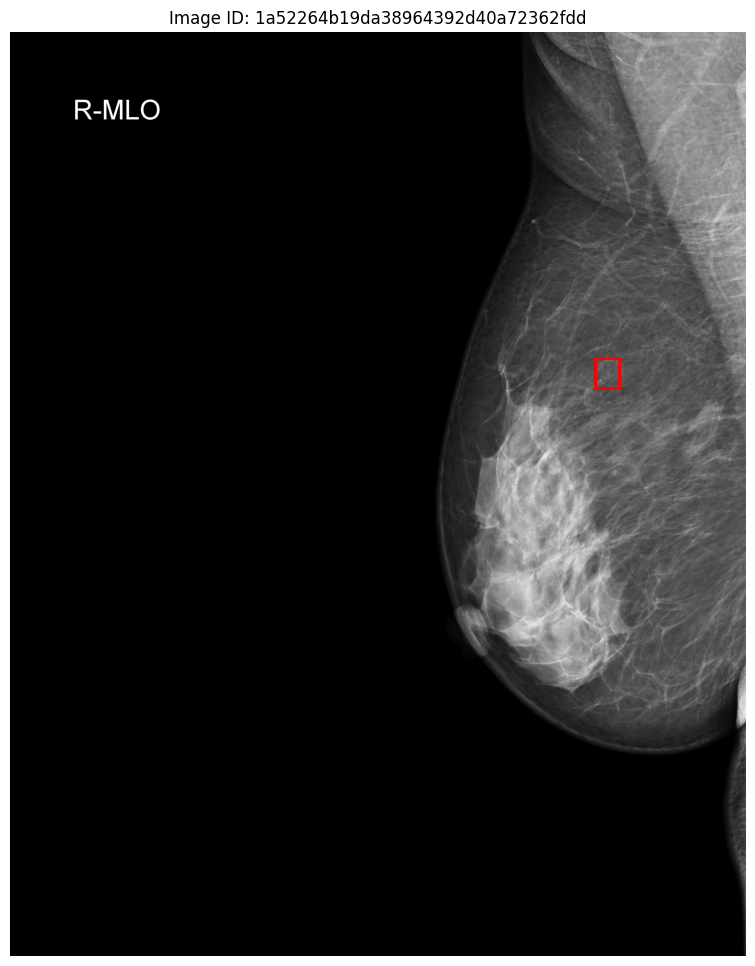

In [1]:
import os
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pydicom.pixel_data_handlers.util import apply_voi_lut
import ast

# Ruta al dataset DICOM
dicom_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/Images_Mass_Calc'

# Ruta a los CSV de anotaciones y metadatos
annotations_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/csv/filtered_with_image_names.csv'
metadata_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/metadata.csv'

# Cargar las anotaciones y el archivo de metadatos
findings = pd.read_csv(annotations_csv)
metadata = pd.read_csv(metadata_csv)

# Si 'finding_categories' es una cadena con listas, puedes convertirla usando ast.literal_eval
# En caso contrario, puedes omitir esta línea
# findings['finding_categories'] = findings['finding_categories'].apply(ast.literal_eval)

# Función para obtener la ruta del archivo DICOM dado el image_id y study_id
def get_dicom_path(image_id, study_id, root_dir):
    return os.path.join(root_dir, study_id, image_id + '.dicom')

# Función para leer el archivo DICOM y aplicar VOI LUT (si está disponible)
def read_dicom_image(image_id, study_id):
    dicom_path = get_dicom_path(image_id, study_id, dicom_root)
    dicom = pydicom.dcmread(dicom_path)
    # Aplicar VOI LUT para ajustar la imagen según el DICOM
    image = apply_voi_lut(dicom.pixel_array, dicom)
    return dicom, image

# Función para dibujar las cajas delimitadoras en la imagen
def draw_bounding_boxes(ax, image_id):
    # Obtener anotaciones para la imagen
    image_annotations = findings[findings['image_id'] == image_id]
    
    for idx, row in image_annotations.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        width, height = xmax - xmin, ymax - ymin
        
        # Dibujar la caja delimitadora
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Mostrar información de la ROI (opcional)
        print(f"ROI #{idx+1}: {row['finding_categories']}, BIRADS: {row['finding_birads']}")

# Función para filtrar imágenes que tienen findings
def filter_images_with_findings():
    # Filtrar imágenes que no contengan "No Finding" en la categoría
    findings_with_finding = findings[findings['finding_categories'] != 'No Finding']
    return findings_with_finding

# Función para asociar el image_id de findings con SOP Instance UID de metadata
def get_metadata_info(image_id):
    # Buscar la imagen correspondiente en el metadata usando el SOP Instance UID
    metadata_info = metadata[metadata['SOP Instance UID'] == image_id]
    if not metadata_info.empty:
        # Extraer la información de las columnas relevantes
        photometric_interpretation = metadata_info['Photometric Interpretation'].values[0]
        window_center_width_explanation = metadata_info['Window Center & Width Explanation'].values[0]
        return photometric_interpretation, window_center_width_explanation
    else:
        return None, None

# Función para mostrar una imagen DICOM aleatoria en alta resolución con ROI y metadatos
def show_random_dicom_with_roi_and_metadata():
    # Filtrar las filas que tienen findings
    findings_with_finding = filter_images_with_findings()
    
    if findings_with_finding.empty:
        print("No se encontraron imágenes con findings.")
        return
    
    # Seleccionar una fila aleatoria del dataset filtrado
    random_row = findings_with_finding.sample(n=1).iloc[0]
    
    # Obtener el image_id y study_id de la imagen seleccionada
    image_id = random_row['image_id']
    study_id = random_row['study_id']
    
    print(f"Mostrando imagen aleatoria con ID: {image_id} y Study ID: {study_id}")
    
    # Leer la imagen DICOM
    dicom, image = read_dicom_image(image_id, study_id)
    
    # Manejar Photometric Interpretation si es MONOCHROME1 (invertir la imagen)
    photometric_interpretation = dicom.get('PhotometricInterpretation', 'UNKNOWN')
    if photometric_interpretation == 'MONOCHROME1':
        image = image.max() - image
        print(f"Imagen {image_id} tiene Photometric Interpretation: {photometric_interpretation} (invertida)")
    else:
        print(f"Imagen {image_id} tiene Photometric Interpretation: {photometric_interpretation}")
    
    # Normalizar la imagen para mostrarla correctamente
    image = (image - image.min()) / (image.max() - image.min()) * 255
    image = image.astype('uint8')
    
    # Mostrar la imagen a alta resolución
    fig, ax = plt.subplots(figsize=(12, 12))  # Tamaño más grande para alta resolución
    ax.imshow(image, cmap='gray')
    
    # Dibujar las cajas delimitadoras en la imagen
    draw_bounding_boxes(ax, image_id)
    
    # Obtener información de metadatos del CSV 'metadata.csv'
    photometric_interpretation_csv, window_center_width_explanation = get_metadata_info(image_id)
    
    if photometric_interpretation_csv and window_center_width_explanation:
        print(f"\nMetadatos asociados a la imagen:")
        print(f"Photometric Interpretation (desde CSV): {photometric_interpretation_csv}")
        print(f"Window Center & Width Explanation: {window_center_width_explanation}")
    else:
        print("\nNo se encontraron metadatos para esta imagen.")
    
    ax.set_title(f"Image ID: {image_id}")
    ax.axis('off')  # Ocultar los ejes para mejor visualización
    plt.show()

# Mostrar una imagen DICOM aleatoria con su ROI y metadatos
show_random_dicom_with_roi_and_metadata()


Mostrando imagen aleatoria con ID: 2fc787f72bfa6b6c0bbc0a85413c8a9f, Nombre de imagen: 2fc787f72bfa6b6c0bbc0a85413c8a9f_0, y Study ID: 35eb15c7c9522cfb54e75dcbb73f1e55
Imagen 2fc787f72bfa6b6c0bbc0a85413c8a9f_0 tiene Photometric Interpretation: MONOCHROME2

Metadatos asociados a la imagen:
Photometric Interpretation (desde CSV): MONOCHROME2
Window Center & Width Explanation: linear LUT
ROI #405: Suspicious Calcification, BIRADS: BI-RADS 5
ROI #406: Mass, BIRADS: BI-RADS 4
ROI #407: Mass, BIRADS: BI-RADS 4
Recorte ROI #405: Suspicious Calcification, BIRADS: BI-RADS 5


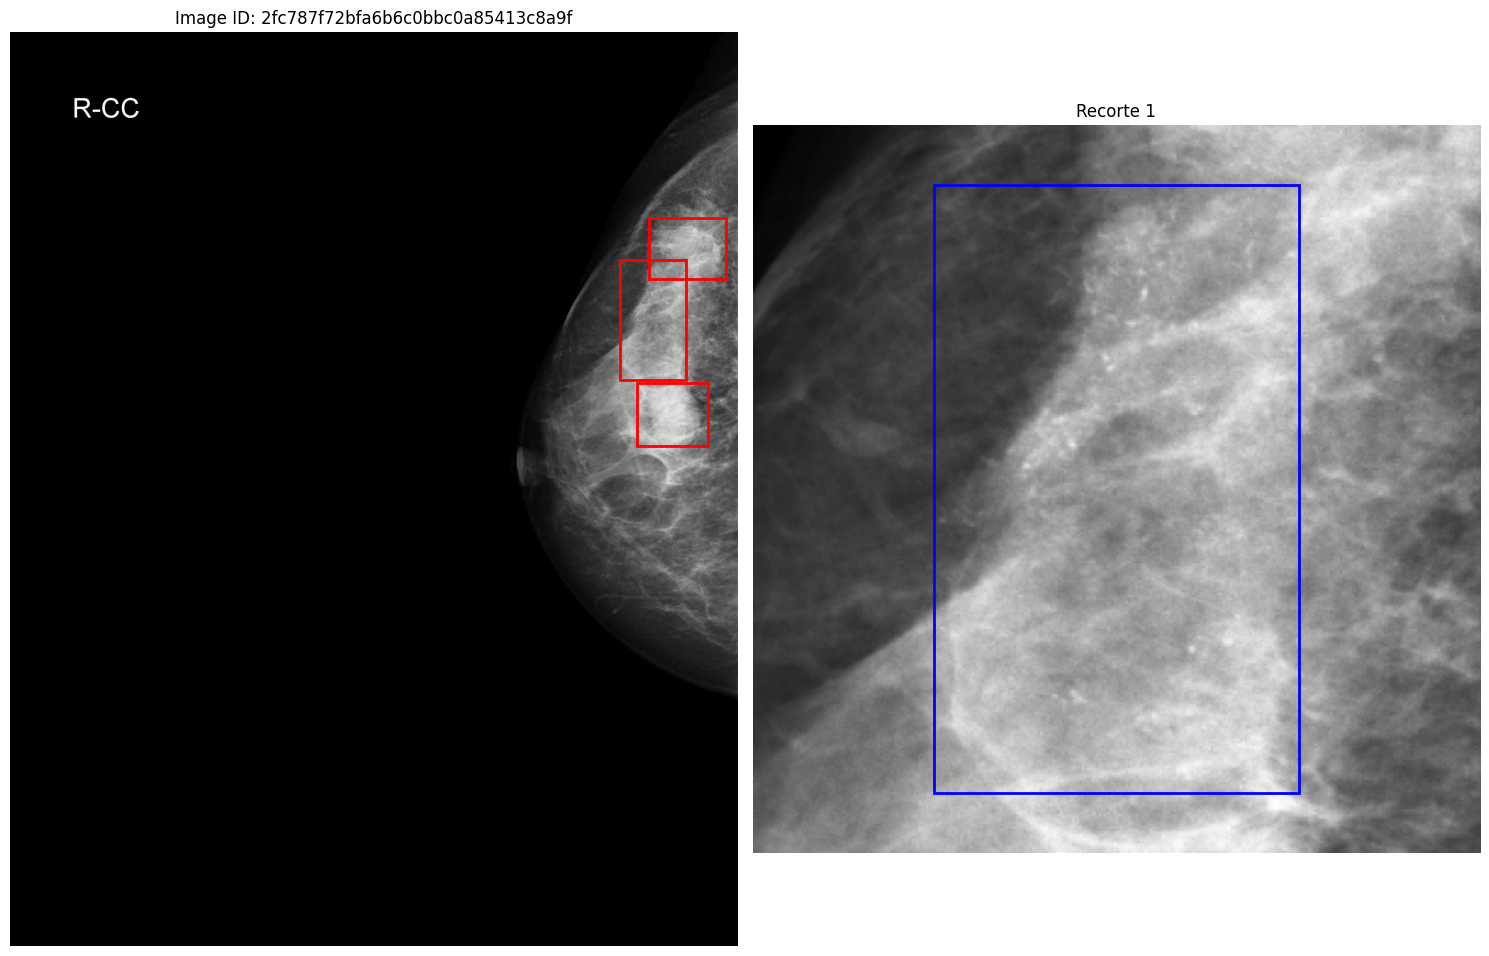

In [29]:
import os
import cv2
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pydicom.pixel_data_handlers.util import apply_voi_lut
import ast

# Rutas al dataset DICOM y directorios de recortes
dicom_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/images_with_other'
roicrop1_dir = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/roi_images/ROICROP8'  # Ruta a ROICROP2

# Rutas a los CSV de anotaciones y metadatos
annotations_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/csv/others_with_image_names.csv'
crop2_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/csv/CROP8.csv'  # Ruta a CROP2.csv
metadata_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/metadata.csv'

# Cargar las anotaciones y el archivo de metadatos
findings = pd.read_csv(annotations_csv)
metadata = pd.read_csv(metadata_csv)
crops = pd.read_csv(crop2_csv)  # Cargar CROP2.csv

# Limpiar las categorías eliminando los caracteres adicionales
findings['finding_categories'] = findings['finding_categories'].apply(lambda x: x.strip("[]'"))

# Crear un DataFrame vacío para las nuevas coordenadas
ss1_rescaled = pd.DataFrame(columns=findings.columns)

# Lista de categorías para 'otros'
otros_categories = [
    'Focal Asymmetry',
    'Architectural Distortion',
    'Asymmetry',
    'Suspicious Lymph Node',
    'Skin Thickening',
    'Global Asymmetry',
    'Nipple Retraction',
    'Skin Retraction'
]

# Función para obtener la ruta del archivo DICOM dado el image_id y study_id
def get_dicom_path(image_id, study_id, root_dir):
    possible_extensions = ['.dicom', '.dcm', '']
    study_path = os.path.join(root_dir, study_id)
    if not os.path.isdir(study_path):
        print(f"Advertencia: El directorio del estudio '{study_id}' no existe en '{root_dir}'.")
        return None
    for ext in possible_extensions:
        dicom_filename = image_id + ext
        dicom_path = os.path.join(study_path, dicom_filename)
        if os.path.exists(dicom_path):
            return dicom_path
    print(f"Advertencia: No se encontró el archivo DICOM para image_id: {image_id} en '{study_path}'.")
    return None

# Función para mapear BIRADS a categorías
def map_birads_to_category(birads):
    if birads in ['BI-RADS 0', 'BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3']:
        return 'benigno'
    elif birads == 'BI-RADS 4':
        return 'sospechoso'
    elif birads in ['BI-RADS 5', 'BI-RADS 6']:
        return 'maligno'
    else:
        print(f"Advertencia: BIRADS desconocido '{birads}'. Asignando a 'benigno'.")
        return 'benigno'

# Función para aplicar el recorte basado en el centro de la ROI, con padding variable
def extract_roi(image_name, split, birads, finding_category, ss1_rescaled):
    # Obtener el image_id (parte antes del guión bajo "_")
    image_id = image_name.split('_')[0]
    study_id = image_name.split('_')[1] if '_' in image_name else ''  # Asumiendo que el study_id está después del primer '_'
    dicom_path = get_dicom_path(image_id, study_id, dicom_root)
    
    if dicom_path is None:
        print(f"Error: No se encontró el archivo DICOM para la imagen {image_name}.")
        return ss1_rescaled

    # Leer la imagen DICOM
    try:
        dicom = pydicom.dcmread(dicom_path)
        original_image = dicom.pixel_array
    except Exception as e:
        print(f"Error al leer el archivo DICOM para la imagen {image_name}: {e}")
        return ss1_rescaled

    # Aplicar VOI LUT
    try:
        img_windowed = apply_voi_lut(original_image, dicom, prefer_lut=True)
    except Exception as e:
        print(f"Error al aplicar VOI LUT para la imagen {image_name}: {e}")
        return ss1_rescaled

    # Normalizar la imagen
    try:
        img_windowed = (img_windowed - img_windowed.min()) / (img_windowed.max() - img_windowed.min()) * 255
        img_windowed = img_windowed.astype(np.uint8)
    except Exception as e:
        print(f"Error al normalizar la imagen {image_name}: {e}")
        return ss1_rescaled

    # Extraer las coordenadas de la ROI
    try:
        x1 = int(findings.loc[findings['image_name'] == image_name, 'xmin'].values[0])
        y1 = int(findings.loc[findings['image_name'] == image_name, 'ymin'].values[0])
        x2 = int(findings.loc[findings['image_name'] == image_name, 'xmax'].values[0])
        y2 = int(findings.loc[findings['image_name'] == image_name, 'ymax'].values[0])
    except IndexError:
        print(f"Error: No se encontraron coordenadas para la ROI de la imagen {image_name}.")
        return ss1_rescaled

    # Verificar que las coordenadas sean válidas
    if x1 >= x2 or y1 >= y2:
        print(f"Error: Coordenadas inválidas para la imagen {image_name}. x1: {x1}, x2: {x2}, y1: {y1}, y2: {y2}")
        return ss1_rescaled

    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(img_windowed.shape[1], x2)
    y2 = min(img_windowed.shape[0], y2)

    # Calcular el centro de la ROI
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2

    # Determinar el tamaño de la ROI original
    width = x2 - x1
    height = y2 - y1

    # Agregar padding variable
    if width < MIN_SIZE or height < MIN_SIZE:
        padding_x = int(width * 0.2)
        padding_y = int(height * 0.2)
    else:
        padding_x = int(width * 0.05)
        padding_y = int(height * 0.05)

    # Establecer los nuevos límites de la imagen recortada
    x1_new = max(center_x - (MIN_SIZE // 2) - padding_x, 0)
    y1_new = max(center_y - (MIN_SIZE // 2) - padding_y, 0)
    x2_new = min(center_x + (MIN_SIZE // 2) + padding_x, img_windowed.shape[1])
    y2_new = min(center_y + (MIN_SIZE // 2) + padding_y, img_windowed.shape[0])

    # Recortar la imagen
    crop = img_windowed[y1_new:y2_new, x1_new:x2_new]

    # Verificar si el recorte no está vacío
    if crop.size == 0 or crop.shape[0] == 0 or crop.shape[1] == 0:
        print(f"Error: El recorte para la imagen {image_name} está vacío o tiene dimensiones inválidas.")
        return ss1_rescaled

    # Redimensionar el recorte
    try:
        crop_resized = cv2.resize(crop, TARGET_SIZE)
    except cv2.error as e:
        print(f"Error al redimensionar el recorte para la imagen {image_name}: {e}")
        return ss1_rescaled

    # Calcular las nuevas coordenadas reescaladas
    scale_x = TARGET_SIZE[0] / crop.shape[1]
    scale_y = TARGET_SIZE[1] / crop.shape[0]

    xmin_rescaled = int((x1 - x1_new) * scale_x)
    ymin_rescaled = int((y1 - y1_new) * scale_y)
    xmax_rescaled = int((x2 - x1_new) * scale_x)
    ymax_rescaled = int((y2 - y1_new) * scale_y)

    # Determinar el directorio base según el split
    if split.lower() in ['train', 'training']:
        base_dir = os.path.join(roicrop1_dir, 'training')
    elif split.lower() == 'test':
        base_dir = os.path.join(roicrop1_dir, 'test')
    else:
        print(f"Error: Split desconocido '{split}' para la imagen {image_name}.")
        return ss1_rescaled

    # Determinar la categoría de salida
    if finding_category == 'Mass':
        output_dir = os.path.join(base_dir, 'masas')
    elif finding_category == 'Suspicious Calcification':
        output_dir = os.path.join(base_dir, 'calcificaciones')
    elif finding_category in otros_categories:
        output_dir = os.path.join(base_dir, 'otros')
    else:
        print(f"Error: Categoría desconocida '{finding_category}' para la imagen {image_name}.")
        return ss1_rescaled

    # Mapear BIRADS a categoría
    birads_category = map_birads_to_category(birads)
    output_dir = os.path.join(output_dir, birads_category)

    # Asegurarse de que el directorio de salida existe
    os.makedirs(output_dir, exist_ok=True)

    # Guardar la imagen recortada
    roi_filename = f"{image_name}.png"
    output_path = os.path.join(output_dir, roi_filename)
    try:
        cv2.imwrite(output_path, crop_resized)
        print(f"Imagen ROI guardada en: {output_path}")
    except Exception as e:
        print(f"Error al guardar el recorte para la imagen {image_name}: {e}")
        return ss1_rescaled

    # Guardar las coordenadas reescaladas
    try:
        new_row = findings.loc[findings['image_name'] == image_name].copy()
        new_row['xmin'] = xmin_rescaled
        new_row['ymin'] = ymin_rescaled
        new_row['xmax'] = xmax_rescaled
        new_row['ymax'] = ymax_rescaled
        ss1_rescaled = pd.concat([ss1_rescaled, new_row], ignore_index=True)
    except Exception as e:
        print(f"Error al guardar las coordenadas reescaladas para la imagen {image_name}: {e}")
        return ss1_rescaled

    return ss1_rescaled

# Función para filtrar imágenes que tienen findings
def filter_images_with_findings():
    # Filtrar imágenes que no contengan "No Finding" en la categoría
    findings_with_finding = findings[findings['finding_categories'] != 'No Finding']
    return findings_with_finding

# Función para leer el archivo DICOM y aplicar VOI LUT (si está disponible)
def read_dicom_image(image_id, study_id):
    dicom_path = get_dicom_path(image_id, study_id, dicom_root)
    if dicom_path is None:
        return None, None
    try:
        dicom = pydicom.dcmread(dicom_path)
        # Aplicar VOI LUT con prefer_lut=True (priorizando LUT si está presente)
        image = apply_voi_lut(dicom.pixel_array, dicom)
        return dicom, image
    except Exception as e:
        print(f"Error al leer o procesar el archivo DICOM para {image_id}: {e}")
        return None, None

# Función para dibujar las cajas delimitadoras en la imagen
def draw_bounding_boxes(ax, image_id):
    # Obtener anotaciones para la imagen
    image_annotations = findings[findings['image_id'] == image_id]
    
    for idx, row in image_annotations.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        width, height = xmax - xmin, ymax - ymin
        
        # Dibujar la caja delimitadora
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Mostrar información de la ROI (opcional)
        print(f"ROI #{idx+1}: {row['finding_categories']}, BIRADS: {row['finding_birads']}")

# Función para asociar el image_id de findings con SOP Instance UID de metadata
def get_metadata_info(image_id):
    # Buscar la imagen correspondiente en el metadata usando el SOP Instance UID
    metadata_info = metadata[metadata['SOP Instance UID'] == image_id]
    if not metadata_info.empty:
        # Extraer la información de las columnas relevantes
        photometric_interpretation = metadata_info['Photometric Interpretation'].values[0]
        window_center_width_explanation = metadata_info['Window Center & Width Explanation'].values[0]
        return photometric_interpretation, window_center_width_explanation
    else:
        return None, None

# Función para encontrar y cargar los recortes asociados a una imagen
def get_recortes(image_name):
    recortes = []
    # Recorrer todas las subcarpetas de ROICROP2 (training y test)
    for split in ['training', 'test']:
        split_path = os.path.join(roicrop1_dir, split)
        for category in ['masas', 'calcificaciones', 'otros']:
            category_path = os.path.join(split_path, category)
            if not os.path.isdir(category_path):
                continue
            for birads_category in ['benigno', 'maligno', 'sospechoso']:
                birads_path = os.path.join(category_path, birads_category) if category != 'otros' else category_path
                if not os.path.isdir(birads_path):
                    continue
                # Buscar archivos .png que correspondan al image_name
                for file in os.listdir(birads_path):
                    if file.startswith(image_name) and file.endswith('.png'):
                        recorte_path = os.path.join(birads_path, file)
                        recortes.append(recorte_path)
    return recortes

# Función para dibujar las cajas delimitadoras en los recortes PNG usando CROP2.csv
def draw_bounding_boxes_png(ax, crop_image_name):
    # Obtener anotaciones para el recorte desde CROP2.csv
    crop_annotations = crops[crops['image_name'] == crop_image_name]
    
    for idx, row in crop_annotations.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        width, height = xmax - xmin, ymax - ymin
        
        # Dibujar la caja delimitadora
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

        # Mostrar información de la ROI (opcional)
        print(f"Recorte ROI #{idx+1}: {row['finding_categories']}, BIRADS: {row['finding_birads']}")

# Función para mostrar una imagen DICOM aleatoria en alta resolución con ROI, recortes y metadatos
def show_random_dicom_with_roi_and_recortes_and_metadata():
    # Filtrar las filas que tienen findings
    findings_with_finding = filter_images_with_findings()
    
    if findings_with_finding.empty:
        print("No se encontraron imágenes con findings.")
        return
    
    # Seleccionar una fila aleatoria del dataset filtrado
    random_row = findings_with_finding.sample(n=1).iloc[0]
    
    # Obtener el image_id y study_id de la imagen seleccionada
    image_id = random_row['image_id']
    image_name = random_row['image_name']
    study_id = random_row['study_id']
    
    print(f"Mostrando imagen aleatoria con ID: {image_id}, Nombre de imagen: {image_name}, y Study ID: {study_id}")
    
    # Leer la imagen DICOM
    dicom, image = read_dicom_image(image_id, study_id)
    
    if dicom is None or image is None:
        print(f"No se pudo leer la imagen DICOM para {image_name}.")
        return
    
    # Manejar Photometric Interpretation si es MONOCHROME1 (invertir la imagen)
    photometric_interpretation = dicom.get('PhotometricInterpretation', 'UNKNOWN')
    if photometric_interpretation == 'MONOCHROME1':
        image = image.max() - image
        print(f"Imagen {image_name} tiene Photometric Interpretation: {photometric_interpretation} (invertida)")
    else:
        print(f"Imagen {image_name} tiene Photometric Interpretation: {photometric_interpretation}")
    
    # Normalizar la imagen para mostrarla correctamente
    try:
        image = (image - image.min()) / (image.max() - image.min()) * 255
        image = image.astype('uint8')
    except Exception as e:
        print(f"Error al normalizar la imagen {image_name}: {e}")
        return
    
    # Obtener información de metadatos del CSV 'metadata.csv'
    photometric_interpretation_csv, window_center_width_explanation = get_metadata_info(image_id)
    
    if photometric_interpretation_csv and window_center_width_explanation:
        print(f"\nMetadatos asociados a la imagen:")
        print(f"Photometric Interpretation (desde CSV): {photometric_interpretation_csv}")
        print(f"Window Center & Width Explanation: {window_center_width_explanation}")
    else:
        print("\nNo se encontraron metadatos para esta imagen.")
    
    # Crear una figura con subplots: 1 para la imagen DICOM y varios para los recortes
    recortes_paths = get_recortes(image_name)
    num_recortes = len(recortes_paths)
    
    if num_recortes == 0:
        print(f"No se encontraron recortes para la imagen {image_name} en ROICROP2.")
    
    # Definir el tamaño de la figura
    fig_width = 12 + 3 * num_recortes  # Ajustar según la cantidad de recortes
    fig_height = 12
    fig, axes = plt.subplots(1, max(2, num_recortes + 1), figsize=(fig_width, fig_height))
    
    # Si solo hay un subplot, convertirlo en una lista para iterar
    if num_recortes == 0:
        axes = [axes]
    
    # Mostrar la imagen DICOM
    ax_main = axes[0]
    ax_main.imshow(image, cmap='gray')
    draw_bounding_boxes(ax_main, image_id)
    ax_main.set_title(f"Image ID: {image_id}")
    ax_main.axis('off')  # Ocultar los ejes para mejor visualización
    
    # Mostrar los recortes asociados
    for idx, recorte_path in enumerate(recortes_paths):
        try:
            recorte = cv2.imread(recorte_path, cv2.IMREAD_GRAYSCALE)
            if recorte is None:
                print(f"Error: No se pudo leer el recorte en {recorte_path}.")
                continue
            # Normalizar el recorte
            recorte = (recorte - recorte.min()) / (recorte.max() - recorte.min()) * 255
            recorte = recorte.astype('uint8')
            
            ax = axes[idx + 1]
            ax.imshow(recorte, cmap='gray')
            ax.set_title(f"Recorte {idx + 1}")
            ax.axis('off')
            
            # Obtener el nombre del recorte sin extensión
            recorte_name = os.path.splitext(os.path.basename(recorte_path))[0]
            
            # Dibujar bounding boxes en el recorte utilizando CROP2.csv
            draw_bounding_boxes_png(ax, recorte_name)
        except Exception as e:
            print(f"Error al procesar el recorte {recorte_path}: {e}")
            continue
    
    plt.tight_layout()
    plt.show()

# Ejecutar la función para mostrar una imagen DICOM aleatoria con sus recortes y metadatos
show_random_dicom_with_roi_and_recortes_and_metadata()


In [20]:
### contamos las imágenes generadas

In [21]:
import os

def count_png_images(output_root):
    """
    Cuenta la cantidad de imágenes .png en cada subdirectorio de ROICROP8.

    Parámetros:
    - output_root (str): Ruta al directorio ROICROP8.

    Retorna:
    - None: Imprime los resultados en la consola.
    """
    counts = {}
    total_images = 0

    # Definir splits y categorías
    splits = ['training', 'test']
    categories = ['masas', 'calcificaciones', 'otros']
    birads_categories = ['benigno', 'maligno', 'sospechoso']

    for split in splits:
        split_path = os.path.join(output_root, split)
        if not os.path.isdir(split_path):
            print(f"Advertencia: El directorio split '{split}' no existe en '{output_root}'.")
            continue
        
        counts[split] = {}
        for category in categories:
            category_path = os.path.join(split_path, category)
            if not os.path.isdir(category_path):
                print(f"Advertencia: El directorio categoría '{category}' no existe en '{category_path}'.")
                continue
            
            counts[split][category] = {}
            for birads in birads_categories:
                birads_path = os.path.join(category_path, birads)
                if not os.path.isdir(birads_path):
                    print(f"Advertencia: El directorio BIRADS '{birads}' no existe en '{birads_path}'.")
                    continue
                
                # Contar archivos .png (ignorando mayúsculas/minúsculas)
                png_files = [f for f in os.listdir(birads_path) if f.lower().endswith('.png')]
                count = len(png_files)
                counts[split][category][birads] = count
                total_images += count

    # Imprimir los resultados
    print("\nCantidad de imágenes .png por categoría y subcategoría:")
    for split, categories_data in counts.items():
        print(f"\nSplit: {split.capitalize()}")
        for category, birads_data in categories_data.items():
            print(f"  Categoría: {category.capitalize()}")
            for birads, count in birads_data.items():
                print(f"    {birads.capitalize()}: {count} imágenes")
    
    print(f"\nTotal de imágenes .png en '{output_root}': {total_images}")

# Ruta al directorio ROICROP8
output_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/roi_images/ROICROP8'

# Ejecutar la función de conteo
count_png_images(output_root)



Cantidad de imágenes .png por categoría y subcategoría:

Split: Training
  Categoría: Masas
    Benigno: 443 imágenes
    Maligno: 90 imágenes
    Sospechoso: 372 imágenes
  Categoría: Calcificaciones
    Benigno: 54 imágenes
    Maligno: 33 imágenes
    Sospechoso: 224 imágenes
  Categoría: Otros
    Benigno: 215 imágenes
    Maligno: 43 imágenes
    Sospechoso: 187 imágenes

Split: Test
  Categoría: Masas
    Benigno: 123 imágenes
    Maligno: 14 imágenes
    Sospechoso: 81 imágenes
  Categoría: Calcificaciones
    Benigno: 11 imágenes
    Maligno: 20 imágenes
    Sospechoso: 60 imágenes
  Categoría: Otros
    Benigno: 49 imágenes
    Maligno: 14 imágenes
    Sospechoso: 47 imágenes

Total de imágenes .png en '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/roi_images/ROICROP8': 2080
